In [1]:
import replaceReadsUtils
import pysam
import re
import pandas
from io import StringIO

# set up some demo reads

```
    10
 a: AAAAAAAAAAAAAAAAAAA
 b:      TTTTTTTTTTTTTTTTTTTT
 m: AAAAAAAAAA-----AAAAACCCCC
 m2:       AAA---CCC
 ```

In [2]:
genome = "G"*100
genome_start = 3

a = pysam.AlignedSegment()
qseq = "A"*20
a.query_name = "read1"
a.query_sequence=qseq
a.flag = 0
a.reference_id = 0
a.reference_start = 10
a.mapping_quality = 20
a.cigarstring = str(len(qseq)) + "M"
a.query_qualities = pysam.qualitystring_to_array("<"*len(qseq))
a.tags = (("NM", 1),("RG", "L1"))

b = pysam.AlignedSegment()
qseq = "T"*20
b.query_name = "read2"
b.query_sequence=qseq
b.flag = 0
b.reference_id = 0
b.reference_start = 15
b.mapping_quality = 20
b.cigarstring = str(len(qseq)) + "M"
b.query_qualities = pysam.qualitystring_to_array("<"*len(qseq))
b.tags = (("NM", 1),("RG", "L1"))


m = pysam.AlignedSegment()
qseq = "AAAAAAAAAAAAAAACCCCC"
m.query_name = "mod"
m.query_sequence=qseq
m.flag = 0
m.reference_id = 0
m.reference_start = 10
m.mapping_quality = 20
m.cigarstring = "10M5D10M"
m.query_qualities = pysam.qualitystring_to_array("<"*len(qseq))
m.tags = (("NM", 1),("RG", "L1"))

m2 = pysam.AlignedSegment()
qseq = "AAACCC"
m2.query_name = "mod2"
m2.query_sequence=qseq
m2.flag = 0
m2.reference_id = 0
m2.reference_start = 18
m2.mapping_quality = 20
m2.cigarstring = "3M3D3M"
m2.query_qualities = pysam.qualitystring_to_array("<"*len(qseq))
m2.tags = (("NM", 1),("RG", "L1"))

# Demo inserting the edit in m2 into read b

Read b has 20 T's. Read m2 has 3 A's, a 3bp deletion, and 3 C's. We will insert this into read b.

In [3]:
new = replaceReadsUtils.replaceRead(b,m2,genome,genome_start)

print("read b: " + str(b))
print("read m2: " + str(m2))
print("new:" + str(new))

read b: read2	0	0	15	20	20M	-1	-1	20	TTTTTTTTTTTTTTTTTTTT	array('B', [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27])	[('NM', 1), ('RG', 'L1')]
read m2: mod2	0	0	18	20	3M3D3M	-1	-1	6	AAACCC	array('B', [27, 27, 27, 27, 27, 27])	[('NM', 1), ('RG', 'L1')]
new:read2	0	0	15	20	6M3D14M	-1	-1	20	TTTAAACCCTTTTTTTTGGG	array('B', [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27])	[('NM', 1), ('RG', 'L1')]


Note that the new read is the same seqencing length as the original read b, but that it now includes a 3bp deletion as shown in the cigar sequence.

# Demo creating simulated datasets at the EMX1 locus

In [4]:
! if [ ! -f data/chr2.fa ]; then gunzip data/chr2.fa.gz; fi
!mkdir -p out

In [5]:
!python replaceReads.py --downsampleNumber 100 --swapFreq 0.5 \
    --qualAdd 0 --swapChr chr2 --swapLoc 72933870 --reference data/chr2.fa \
    --unalteredBam data/unaltered.bam --unalteredNamesortedBam data/unaltered.nameSort.bam \
    --alteredBam data/ampSeq.bam \
    --outfile out/demo.bam  \
    --onlyIncludeAlteredWithIndel

Namespace(alteredBam='data/ampSeq.bam', downsampleNumber=100, onlyIncludeAlteredWithIndel=True, outfile='out/demo.bam', qualAdd=0, reference='data/chr2.fa', swapChr='chr2', swapFreq=0.5, swapLoc=72933870, unalteredBam='data/unaltered.bam', unalteredNamesortedBam='data/unaltered.nameSort.bam')
fetching chr2:72933870
read 274 reads, kept 273 reads at target
making changes in 50/273 sites
sorting...
sorting control...
Finished
read 16000 reads
printed 5522 reads not at the cut site (downsample pct was 0.36496350364963503)
printed 50 reads at cut site without modification
printed 50 reads at cut site with modification
printed 5622 reads to the treatment bam
printed 6016 reads to the control bam



# Run Pindel on simulated dataset

In [6]:
#the -e flag doesn't exist in all echo versions
!echo "out/demo.bam.ctl.bam	550	NORMAL" > out/demo.pindelConfig
!echo "out/demo.bam	550	TUMOR" >> out/demo.pindelConfig

In [7]:
!pindel -f data/chr2.fa -i out/demo.pindelConfig -o out/demo.pindel

Initializing parameters...
Pindel version 0.2.5b8, 20151210.
Loading reference genome ...
Loading reference genome done.
Initializing parameters done.
SearchRegion::SearchRegion
Processing region: chr2	1	242193529
Chromosome Size: 242193530
NumBoxes: 60006	BoxSize: 8079

Looking at chromosome chr2 bases 1 to 5000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close 

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 30000001 to 35000001 of the bed region: chromosome chr2:1-242193529 
out/demo.bam.ctl.bam RP 2
out/demo.bam RP 7
Discovery RP: 7
sorting RP complete.
Reads_RP.size(): 7
sorting read-pair
sorting read-pair finished.
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	2, + 1 - 1
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one end mapped rea

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 60000001 to 65000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one en

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 85000001 to 90000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one en

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 115000001 to 120000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one 

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 145000001 to 150000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one 

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 175000001 to 180000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one 


Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam
BAM file index	1
Bam file name	out/demo.bam
Number of split-reads so far	0

The number of one end mapped read: 0
There are 0 reads supporting the reference allele.
There are 2 samples.
SampleName2Index done
declaring g_RefCoverageRegion for 2 s

no reads 
InterChromosome_SR.size(): 0

Looking at chromosome chr2 bases 230000001 to 235000001 of the bed region: chromosome chr2:1-242193529 
No discordant RP reads in Bamfile out/demo.bam.ctl.bam
No discordant RP reads in Bamfile out/demo.bam
Discovery RP: 0
sorting RP complete.
Reads_RP.size(): 0
Modify RP complete.
adding BD from RP.
modify and summarize interchr RP.
adding BD from interChr RP.
summarize BP as BD complete. Now start sorting BD...
sorting BD... done.
external BD events: 0 Added BreakDancer-like events: 0

Insertsize in config: 550
The number of one end mapped read: 0
Number of problematic reads in current window:            	0, + 0 - 0
Number of split-reads where the close end could be mapped:	0, + 0 - 0
Percentage of problematic reads with close end mapped:    	+ 0.00% - 0.00%
No currentState.Reads for chr2 found in out/demo.bam.ctl.bam
BAM file index	0
Bam file name	out/demo.bam.ctl.bam
Number of split-reads so far	0


Insertsize in config: 550
The number of one 

## Inserted mutations:

In [8]:
!more out/demo.bam.mutations.txt

BP	INDEL	LOC	COUNT
21	D	72933855	3
21	D	72933861	1
1	D	72933918	1
2	D	72933924	1
1	D	72933867	6
46	D	72933824	1
1	I	72933867	20
3	D	72933862	4
2	D	72933730	1
2	I	72933739	1
2	D	72933868	1
6	D	72933862	3
30	D	72933853	1
2	I	72933868	1
9	D	72933859	1
1	I	72933868	1
28	D	72933849	1
1	D	72933864	1
7	D	72933866	1
21	D	72933854	1
1	D	72933766	1
29	D	72933847	1


## Deletions found by Pindel:

In [9]:
!head out/demo.pindel_D

####################################################################################################
0	D 2	NT 0 ""	ChrID chr2	BP 72928818	72928821	BP_range 72928818	72928822	Supports 1	1	+ 0	0	- 1	1	S1 2	SUM_MS 60	2	NumSupSamples 1	1	NORMAL 27 27 0 0 0 0	TUMOR 33 33 0 0 1 1
GGGTACAGAAACGTGGCCTGTGGCTTTGAAGATTTCTTACTGAGTGATGAAGGCTAAGTGCAAAGCTTGCACATTTGTGAAACATGCACAGGAAGAATGACTAGGGTCCCCTTTGAGGTCACAGCTGTGGGCTGAGGGGTGTCAGGATagAAACGCTTGAGAAGATGGCTCCAGGAGGCCTCAGACCTGGAAGACTTGGGGGGATGCCTAGGATCCTAGGTTGGAGGGAAAGAAGGGCAGGGTTTGAGGCAGGCAGATGAAGATAGAGCCACCATCTTGGAGCCCAAGGGCAGGGA
                                                                                                                                   CTGAGGGGTGTCAGGAT  AAACGCTTGAGAAGATGGCTCCAGGAGGCCTCAGACCTGGAAGACTTGGGGGGATGCCTAGGATCCTAGGTTGGAGGGAAAGAAGGGCAGGGTTTGAGGCAGGCAGATGAAGATAGAGCCACCATCTTGGA                 	-	72929308	60	TUMOR	@HWI-D00360:8:H88U0ADXX:2:2116:16314:69264/1
################################################################

In [10]:
from collections import defaultdict

resDict = {}
variantsRecovered = defaultdict(int) #variant -> count recovered e.g. 1D -> 5
variantsSimulated = defaultdict(int) # variant -> count simulated e.g. 1D -> 10 (1D was simulated 10 times, and recovered 5 times)
variantsFalseRecovered = {} # variant -> count not simulated (FDR)


cutsIn = "out/demo.bam.info"
cutsFile = open(cutsIn,"r")
readsNotAtSite = "NA"
readsAtSiteNoMod = "NA"
readsAtSiteMod = "NA"
readReads = "NA"
for line in cutsFile:
        m = re.search("printed (\d+) reads at cut site without modification",line)
        if(m):
                readsAtSiteNoMod = m.group(1)
        m = re.search("printed (\d+) reads at cut site with modification",line)
        if(m):
                readsAtSiteMod = m.group(1)
        m = re.search("printed (\d+) reads not at the cut site",line)
        if(m):
                readsNotAtSite = m.group(1)
        m = re.search("read (\d+) reads",line)
        if(m):
                readReads = m.group(1)
cutsFile.close()

mutsIn = "out/demo.bam.mutations.txt"
mutsFile = open(mutsIn,"r")
theseSimulatedMuts = {}
headLine = mutsFile.readline()
#BP INDEL LOC COUNT
for line in mutsFile:
        line.strip()
        lineEls = line.split()
        indelKey = lineEls[0] + " " + lineEls[1] + " " + lineEls[2]
        theseSimulatedMuts[indelKey] = int(lineEls[3])
mutsFile.close()

In [11]:
theseFoundMuts = {}

delCounts = 0
insCounts = 0
pindelSupport = 0
pindelUniqueSupport = 0

pindelFileNames = ["out/demo.pindel_D",
                "out/demo.pindel_SI",
                "out/demo.pindel_LI",
                ]
for pindelFileName in pindelFileNames:
        pindelFile = open(pindelFileName,"r")
        for line in pindelFile:
                lineEls = line.split()
                if len(lineEls) > 20:
                        if lineEls[25] != "SUM_MS":
                                raise Exception("Can't read line " + line + " (got lineEls[25] = " + lineEls[25] + ")")

                        #BP INDEL LOC => COUNT
                        thisKey = lineEls[2] + " " + lineEls[1] + " " + lineEls[9]
                        theseFoundMuts[thisKey] = int(lineEls[15]) #pindel Support

        pindelFile.close()

In [12]:
thisSimulatedCount = 0
thisSimulatedRecoveredCount = 0
for simulatedKey in theseSimulatedMuts:
        thisSimulatedCount += theseSimulatedMuts[simulatedKey]
        thisRecoveredCount = 0
        if simulatedKey in theseFoundMuts:
                thisRecoveredCount = theseFoundMuts[simulatedKey]
                thisSimulatedRecoveredCount += thisRecoveredCount

        (simLen,simType,simLoc) = simulatedKey.split()
        varKey = simLen + "\t" + simType

        variantsRecovered[varKey] += thisRecoveredCount  #variant -> count recovered e.g. 1D -> 5
        variantsSimulated[varKey] += theseSimulatedMuts[simulatedKey] # variant -> count simulated e.g. 1D -> 10 (1D was simulated 10 times, and recovered 5 times)

In [13]:
swapLoc = 72933870 #site of CRISPR mutation
tolerance = [10,50,100] #how far away from site we should look for false positives

thisFoundCount = 0
thisFoundSimulatedCount = 0
for foundKey in theseFoundMuts:
        thisFoundCount += theseFoundMuts[foundKey]
        if foundKey in theseSimulatedMuts:
                thisFoundSimulatedCount += theseSimulatedMuts[foundKey]
        else:
                (foundLen,foundType,foundLoc) = foundKey.split()
                #make sure this was within 5bp from cut site.. don't want to include too many false positives
                varKey = foundLen + "\t" + foundType
                for t in tolerance:
                        if abs(int(foundLoc) - swapLoc) <= t:
                                if varKey not in variantsFalseRecovered:
                                        variantsFalseRecovered[varKey] = defaultdict(int)
                                variantsFalseRecovered[varKey][t] += theseFoundMuts[foundKey]

In [14]:
outStr = "Length\tType\tSimulated\tRecovered"
for t in tolerance:
    outStr += "\tFDR"+str(t)
outStr += "\n"
for mutKey in sorted(set(variantsSimulated.keys()).union(variantsFalseRecovered.keys())):
        outStr += mutKey+"\t"+str(variantsSimulated[mutKey]) + "\t" + str(variantsRecovered[mutKey])
        if mutKey in variantsFalseRecovered:
                for t in tolerance:
                        outStr += "\t" + str(variantsFalseRecovered[mutKey][t])
        else:
                for t in tolerance:
                        outStr += "\t0"
        outStr += "\n"

#print(outStr)
df = pandas.read_table(StringIO(outStr))
df.sort_values('Length')


,Length,Type,Simulated,Recovered,FDR10,FDR50,FDR100
0,1,D,9,7,0,0,0
1,1,I,21,19,0,0,0
2,2,D,3,0,0,0,0
3,2,I,2,0,0,0,0
7,3,D,4,4,0,0,0
11,6,D,3,3,0,0,0
12,7,D,1,1,0,0,0
13,9,D,1,1,0,0,0
4,21,D,5,3,0,0,0
5,28,D,1,1,0,0,0


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

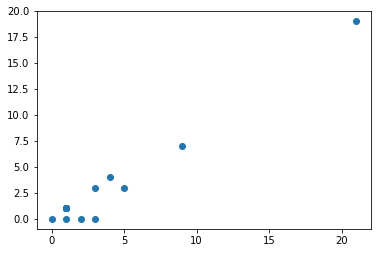

In [16]:
plt.scatter(df.Simulated,df.Recovered)